In [88]:
import pandas as pd
from joblib import dump,load
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import precision_recall_curve
from general_purpose import Binary_classification_assessment, my_rocAuc, crossval_models, \
                            dataframes_charger
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = dataframes_charger("churn.csv")
vars = ["Age","IsActiveMember","NumOfProducts","Balance","HasCrCard","Exited"]
df = df.drop([feature for feature in df.columns if feature not in vars], axis=1)
df.head()

,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,42,0.00,1,1,1,1
1,41,83807.86,1,0,1,0
2,42,159660.80,3,1,0,1
3,39,0.00,2,0,0,0
4,43,125510.82,1,1,1,0


Here we are going to tune the final classifier we are going to use. We have decided to compare:
- Random Forest Classifier
- Gradient Boosting Classifier
- MultinomialNB-GaussianNb Classifier

We are going to divide the process in three steps:

1. Preprocessing  
- for the Number of products we consider that the order of the number is an important information for this feature so we are not going to preprocess it
- the age feature has a similar distribution to the gaussian distribution but it is a bit skewed to the right so we are going to preprocess it with the logarithm to reduce the skewness.
- on the other hand, balance has not have a lot of skewness but a big concentration of people with 0 euros in their account, if we treat it with the power we can see that we are generating skewness to the right so we are going to leave it as it is.


<Axes: ylabel='Frequency'>

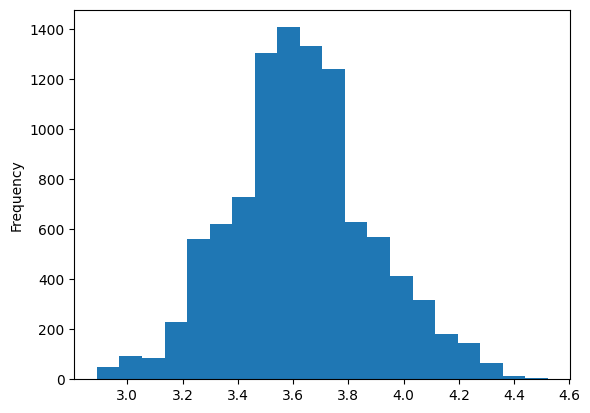

In [17]:
import numpy as np
data_age = pd.Series(np.log(df.Age),name="pre_age")
data_age.plot(kind='hist', bins=20)

<Axes: ylabel='Frequency'>

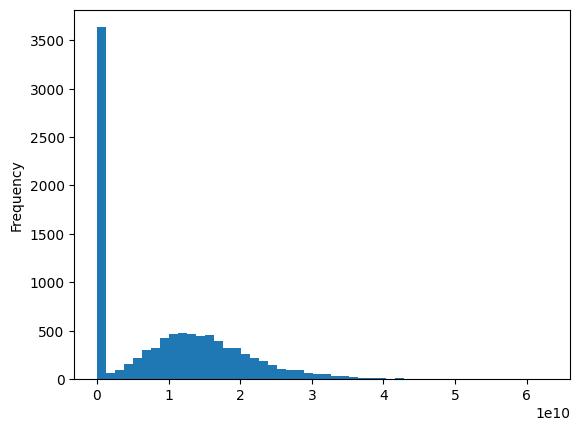

In [16]:
data_balance = np.power(df.Balance,2)
data_balance.plot(kind='hist', bins=50)

<Axes: ylabel='Frequency'>

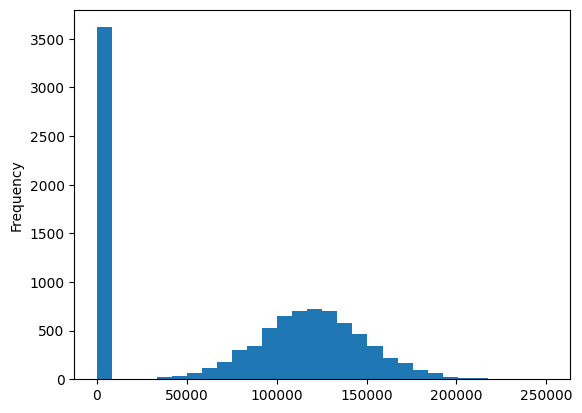

In [5]:
df.Balance.plot(kind='hist', bins=30)

In [21]:
preprocessed_df = pd.concat([df,data_age],axis=1).drop(columns="Age")
preprocessed_df = preprocessed_df[["Balance","pre_age","NumOfProducts","HasCrCard","IsActiveMember","Exited"]]
preprocessed_df.head()

,Balance,pre_age,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,0.00,3.737670,1,1,1,1
1,83807.86,3.713572,1,0,1,0
2,159660.80,3.737670,3,1,0,1
3,0.00,3.663562,2,0,0,0
4,125510.82,3.761200,1,1,1,0


2. Data Balance
Due to the small number of data we are going to choose the oversampling strategy for our balancing policy using the SMOTE algorithm. Reason:
- As the number of data is small we do not want to loose important information.

In [11]:
number_data = len(df)
print(number_data)

10000


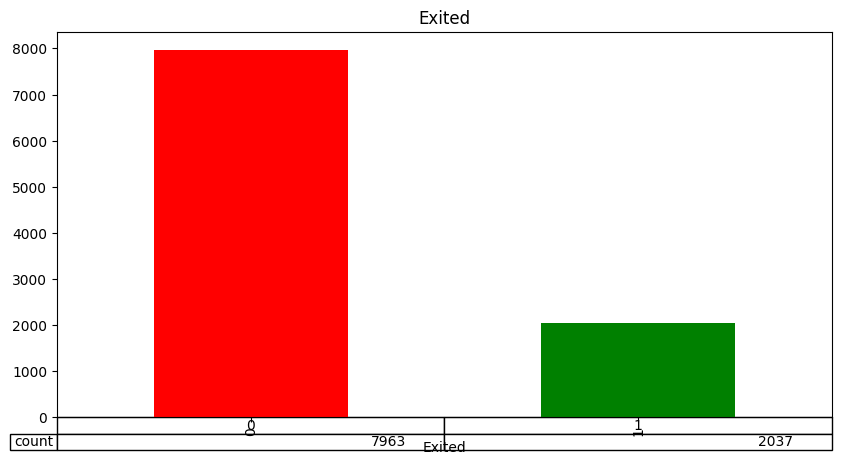

In [30]:
df.Exited.value_counts().plot(kind='bar', 
                              title='Exited',
                              color=["red","green"],
                              table=True,
                              figsize=(10,5));

First we divide the dataset in train and test because we should only apply SMOTE to the training dataset. Otherwise, we will end up with an overfittid model as ...

In [32]:
x = preprocessed_df.iloc[:,:-1]
y = preprocessed_df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [33]:
print(f"shape of x_train: {x_train.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of x_test: {x_test.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of x_train: (8000, 5)
shape of y_train: (8000,)
shape of x_test: (2000, 5)
shape of y_test: (2000,)


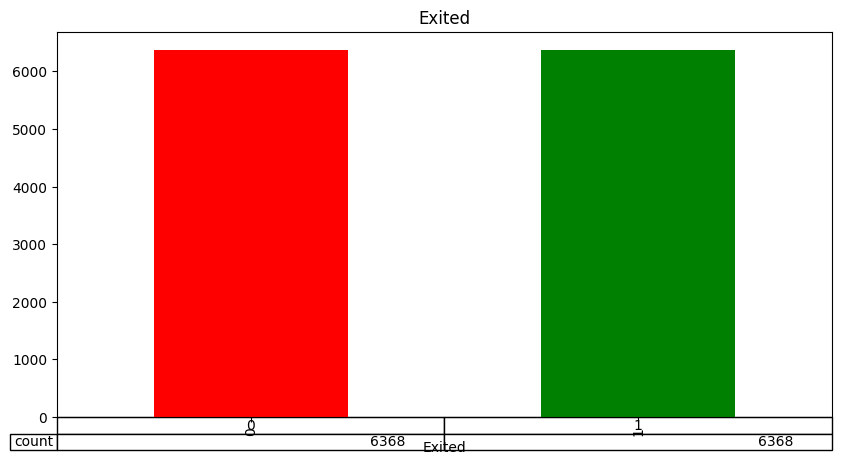

In [34]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(x_train, y_train)

y_smote.value_counts().plot(kind='bar', 
                              title='Exited',
                              color=["red","green"],
                              table=True,
                              figsize=(10,5));

Performance without hyperparameter tunning

In [62]:
def mixed_Nb(x_train,
             y_train,
             testing=True,
             model=None,
             w_discrete=0.5,
             w_continuous=0.5):

    binary_features = x_train[["IsActiveMember","HasCrCard","NumOfProducts"]]
    continuous_features = x_train[["pre_age","Balance"]]

    gaussian = GaussianNB().fit(continuous_features, y_train)
    multinomial = MultinomialNB().fit(binary_features, y_train)
    
    if testing == True:
        scores_discrete = cross_val_predict(multinomial,binary_features,y_train,method="predict_proba",cv=3)
        scores_continuous = cross_val_predict(gaussian, continuous_features, y_train, method="predict_proba", cv=3)

        # product aggregation of probabilities
        combined_scores_prod = scores_discrete * scores_continuous
        combined_scores_prod = combined_scores_prod[:,1]

        # mean aggregation of probabilities
        combined_scores_mean = (scores_discrete + scores_continuous)/2
        combined_scores_mean = combined_scores_mean[:,1]

        # weighted mean aggregation of probabilities
        weighted_mean_scores = w_discrete * scores_discrete + w_continuous * scores_continuous
        weighted_mean_scores = weighted_mean_scores[:,1]

        # colletion of probabilities
        combined_scores = {
            "product_aggregation":combined_scores_prod,
            "mean_aggregation":combined_scores_mean,
            "weighted_mean_aggregation":weighted_mean_scores,
                            }
        # testing models using cross validation prediction
        for name,agg in combined_scores.items():
            print("#"*10 + name + "#"*10)
            precisions,recalls,thresolds = precision_recall_curve(y_train,agg)
            Binary_classification_assessment(precisions,recalls,thresolds,agg,y_train)

            my_rocAuc(y_train,agg)
        
    elif testing == False:
        prob_gaussian = gaussian.predict_proba(continuous_features)
        prob_multinomial = multinomial.predict_proba(binary_features)
        if model == "mean":
            model = (prob_gaussian + prob_multinomial)/2
        elif model == "product":
            model = prob_gaussian * prob_multinomial
        elif model == "weighted":
            model = w_discrete * prob_multinomial + w_continuous * prob_gaussian
        else:
            print("You must provide for parameter model: mean or product")
        return model

    else:
        print("Only accepted values for testing = True or False")



##########product_aggregation##########


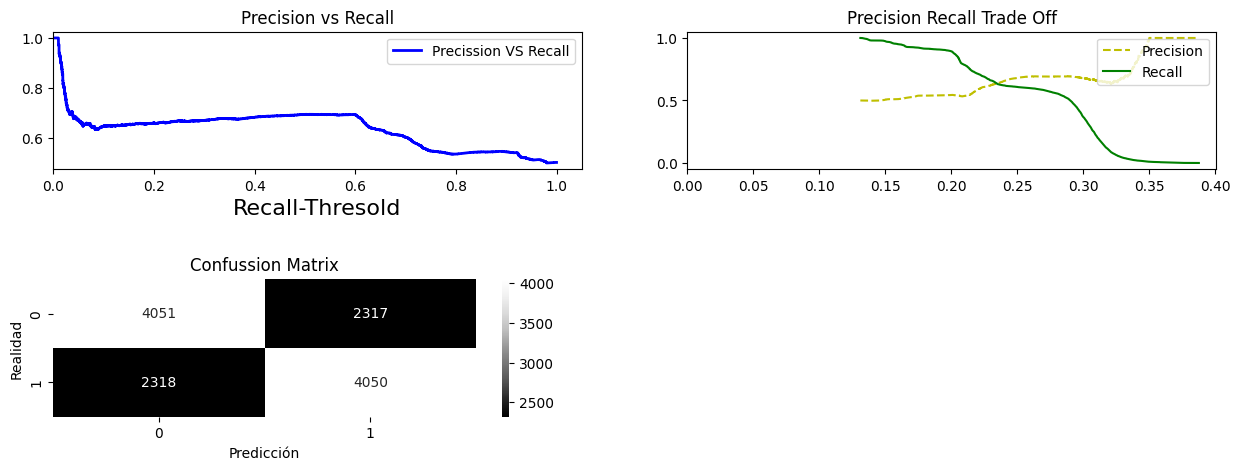

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6368
           1       0.64      0.64      0.64      6368

    accuracy                           0.64     12736
   macro avg       0.64      0.64      0.64     12736
weighted avg       0.64      0.64      0.64     12736



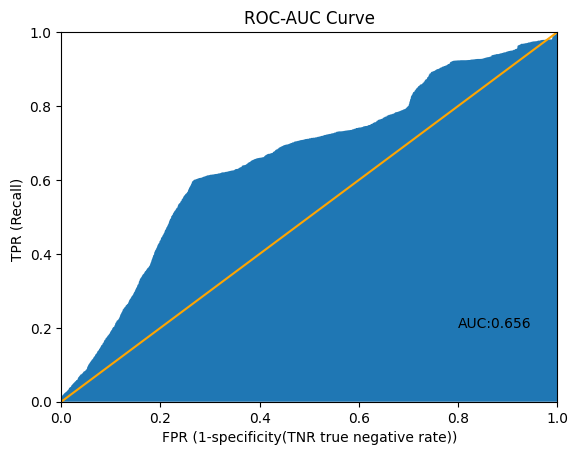

##########mean_aggregation##########


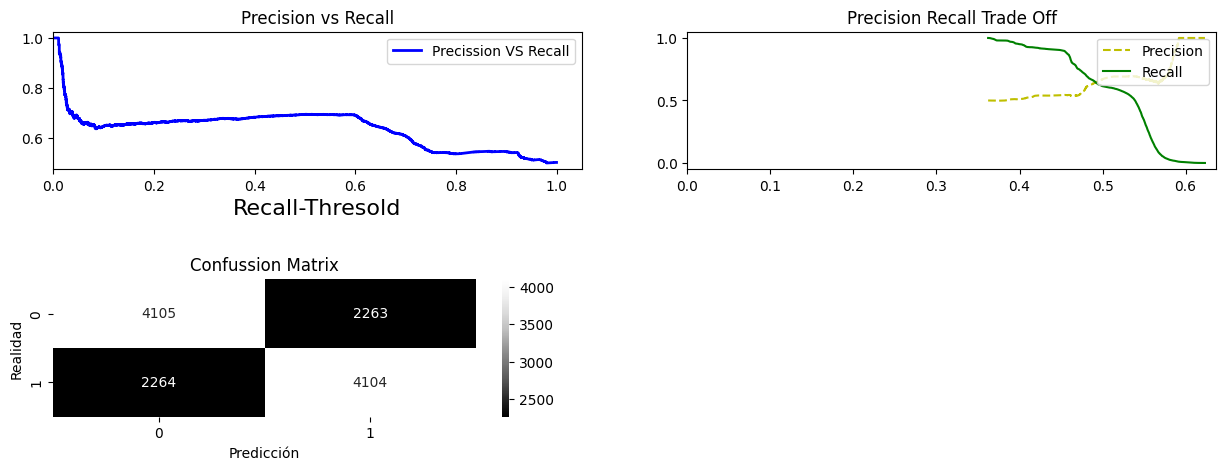

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6368
           1       0.64      0.64      0.64      6368

    accuracy                           0.64     12736
   macro avg       0.64      0.64      0.64     12736
weighted avg       0.64      0.64      0.64     12736



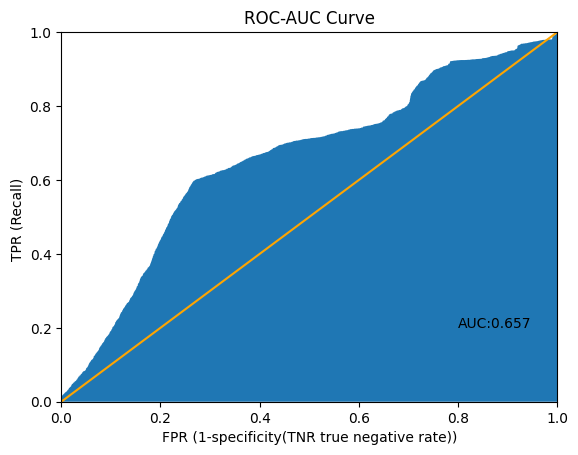

##########weighted_mean_aggregation##########


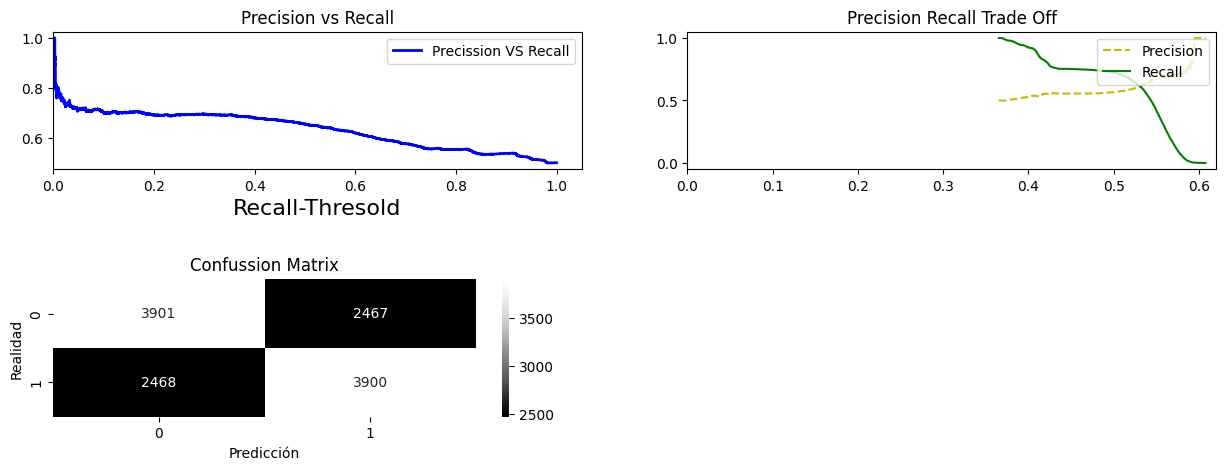

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      6368
           1       0.61      0.61      0.61      6368

    accuracy                           0.61     12736
   macro avg       0.61      0.61      0.61     12736
weighted avg       0.61      0.61      0.61     12736



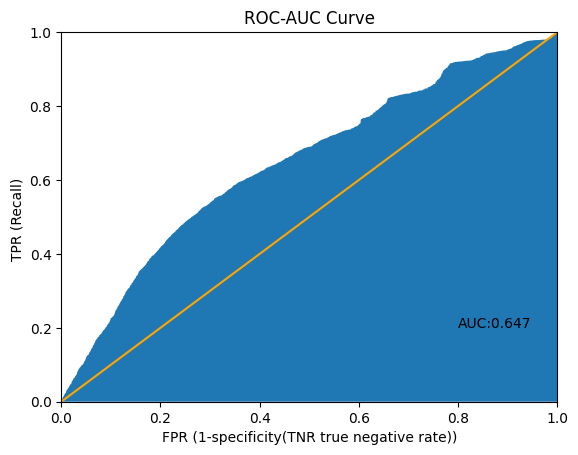

array([0.41429269, 0.48487659, 0.55339225, ..., 0.5617951 , 0.55756782,
       0.42575181])

In [65]:
mixed_Nb(X_smote,
         y_smote,
         w_continuous=0.8,
         w_discrete=0.2)

We have not found sustancial differences between the different ways of probabilities aggregation so any of them would be would. Also we have found that the combined model with oversampling training data is stable and balanced in all its metrics but it is not enough. Tunning the thresold of decision we could improve the recall and obtain the desired metric but we would like not to touch the thresold. Given that case I would choose the product aggregation as I would achieve a better precission for the same recall aiming to a recall greater of 0.8

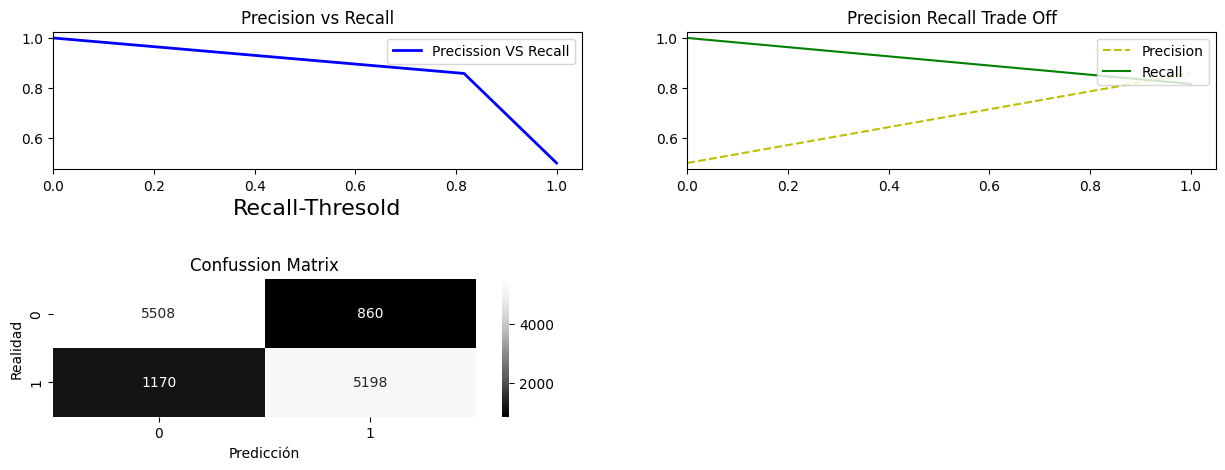

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      6368
           1       0.86      0.82      0.84      6368

    accuracy                           0.84     12736
   macro avg       0.84      0.84      0.84     12736
weighted avg       0.84      0.84      0.84     12736



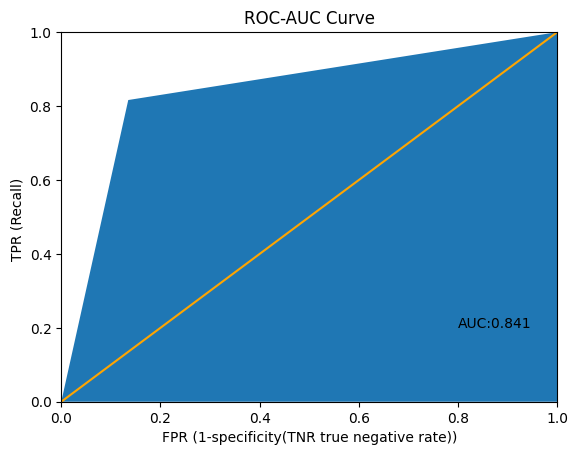

In [70]:
def assess_classifier(estimator,x_train,y_train):
    forest = estimator.fit(x_train,y_train)
    pred = cross_val_predict(forest, x_train, y_train, cv=5)
    precisions,recalls,thresolds = precision_recall_curve(y_train,pred)
    Binary_classification_assessment(precisions,recalls,thresolds,pred,y_train)

    my_rocAuc(y_train,pred)

assess_classifier(RandomForestClassifier(),X_smote,y_smote)

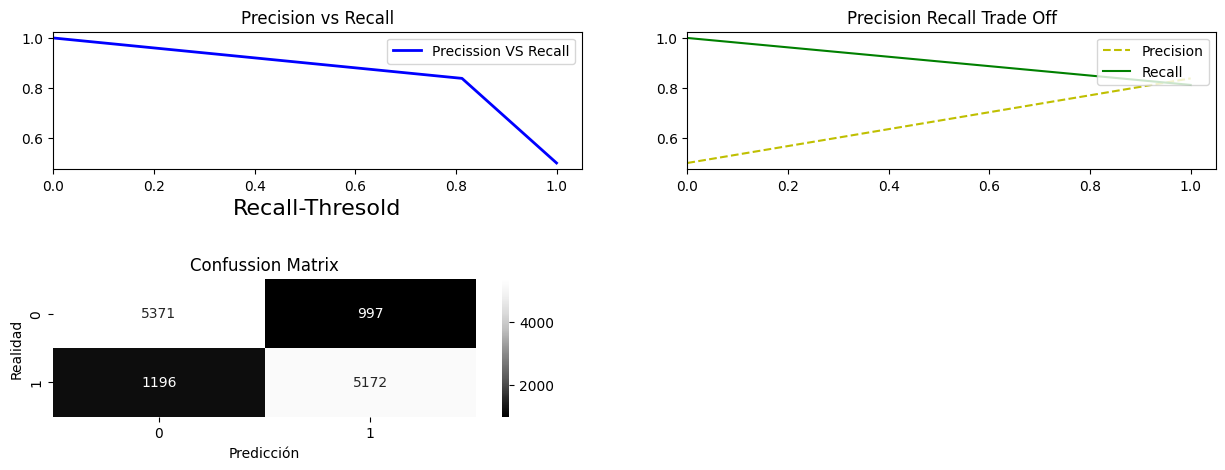

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      6368
           1       0.84      0.81      0.83      6368

    accuracy                           0.83     12736
   macro avg       0.83      0.83      0.83     12736
weighted avg       0.83      0.83      0.83     12736



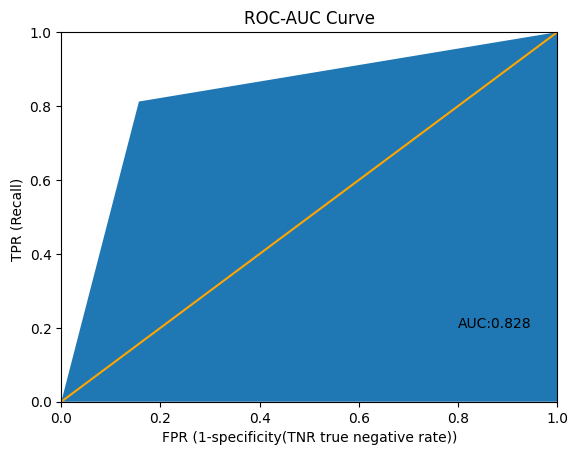

In [71]:
assess_classifier(GradientBoostingClassifier(),X_smote,y_smote)

Definetly we are going to tune the Random Forest and the Gradient Boosting as they are much better than the mixed naive bayes. At this point Random Forest gets slightly better results than Gradient Boosting.

3. Hyperparameter tunning

In [83]:
params = {
    'n_estimators': [300, 350, 400, 450, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [8, 9, 10, 11,12],
    'min_samples_split': [3, 4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 3, 4],
    'subsample': [0.7, 0.75, 0.8, 0.85, 0.9],
    'max_features': ['auto', 'sqrt', 'log2', None]
}


tuner = RandomizedSearchCV(GradientBoostingClassifier(),
                           param_distributions=params,
                           scoring="recall",)

GradientTuned = tuner.fit(X_smote, y_smote)

/Users/fersaol/opt/miniconda3/envs/python3_12_0/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fersaol/opt/miniconda3/envs/python3_12_0/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fersaol/opt/miniconda3/envs/python3_12_0/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/fersaol/opt/miniconda3/envs/python3_12_0/lib/python3.12/site-packages

In [84]:
GradientTuned.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, max_depth=10, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=4,
                           n_estimators=400, subsample=0.85)

In [85]:
GradientTuned.best_score_

0.8404673320171019

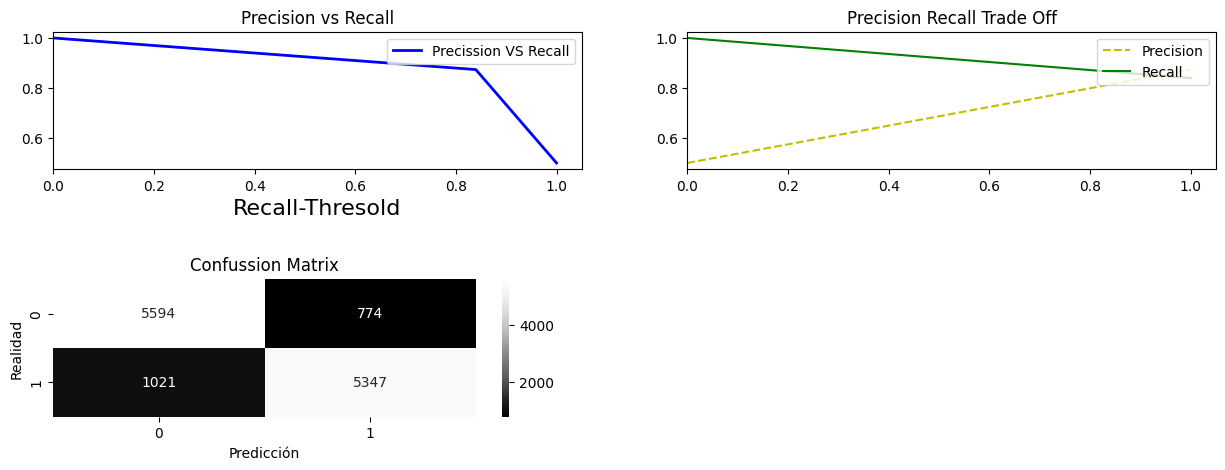

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      6368
           1       0.87      0.84      0.86      6368

    accuracy                           0.86     12736
   macro avg       0.86      0.86      0.86     12736
weighted avg       0.86      0.86      0.86     12736



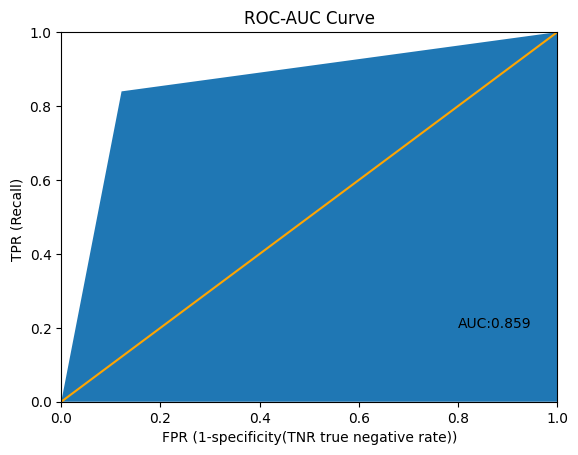

In [86]:
assess_classifier(GradientTuned.best_estimator_,X_smote,y_smote)

In [80]:
params = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [15, 20, 25, 30, 35],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

tuner = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=params,
                           scoring="recall")

randomForestTuned = tuner.fit(X_smote, y_smote)

In [81]:
randomForestTuned.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_split=10)

In [82]:
randomForestTuned.best_score_

0.8224031046946545

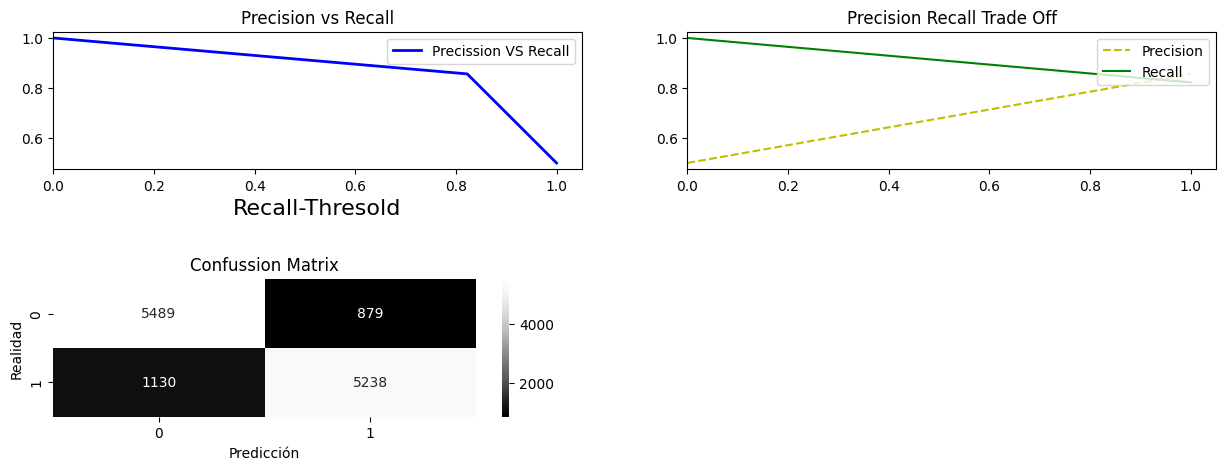

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      6368
           1       0.86      0.82      0.84      6368

    accuracy                           0.84     12736
   macro avg       0.84      0.84      0.84     12736
weighted avg       0.84      0.84      0.84     12736



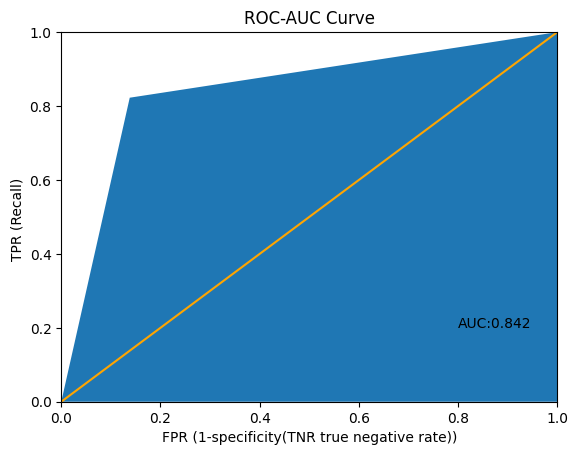

In [87]:
assess_classifier(randomForestTuned,X_smote,y_smote)

Finally we can see that balancing the classes we have been able to get more robust estimator overall and that with the hypertunning we have been able to improve the estimators but it has not been a big difference. The most important thing has been the process and understanding of the data and although we though from the beginning we would choose Random Forest, at the end Gradient Boosting has achieve better metrics, and specifically better in recall that was our target, but with little difference.

In [92]:
def ml_model_manager(name,model,save=True,path=Path.cwd()):

    full_route = Path(path).joinpath(name + ".joblib")

    if save:
        dump(model, full_route)
        print(f"Model {name} saved to {full_route}")
    else:
        model = load(full_route)
        print(f"Model {name} loaded from {full_route}")


In [93]:
ml_model_manager(
    name='ChurningGradientBoostingClassifier_v0',
    model=GradientTuned.best_estimator_
)

Model ChurningGradientBoostingClassifier_v0 saved to /Users/fersaol/Library/CloudStorage/OneDrive-Personal/Documentos/GitHub/ChurnDataScienceProject/ChurningGradientBoostingClassifier_v0.joblib


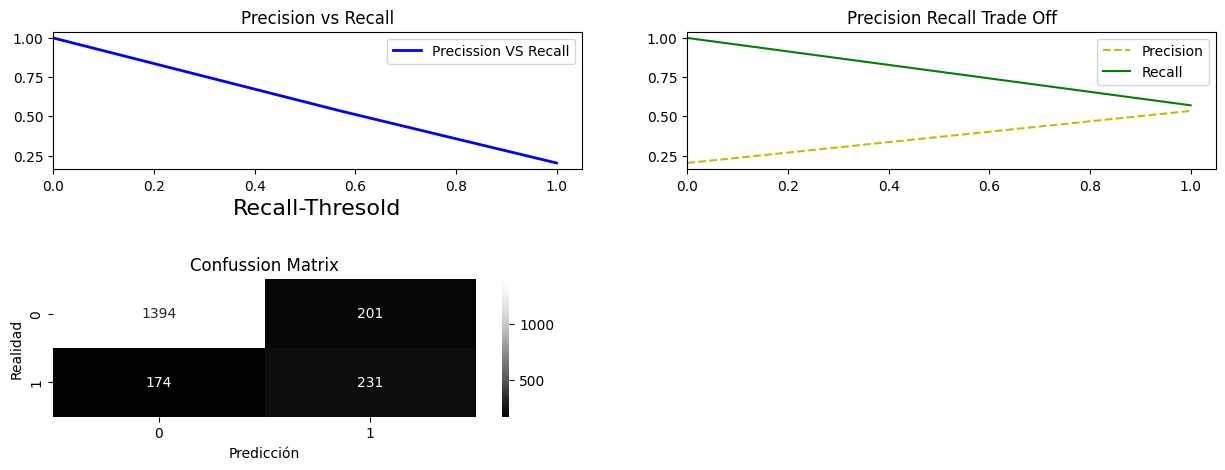

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1595
           1       0.53      0.57      0.55       405

    accuracy                           0.81      2000
   macro avg       0.71      0.72      0.72      2000
weighted avg       0.82      0.81      0.81      2000



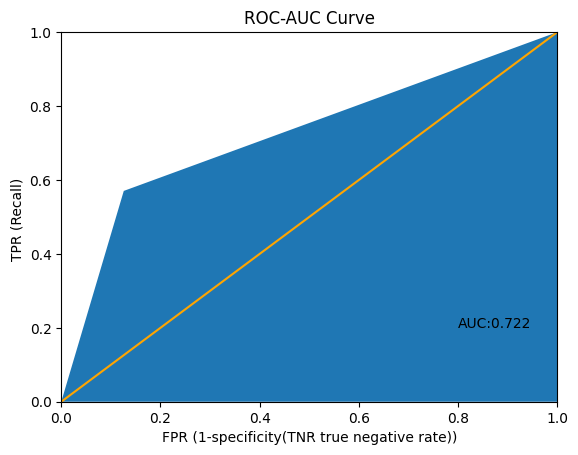

In [99]:
prediction = GradientTuned.predict(x_test)

precisions,recalls,thresolds = precision_recall_curve(y_test,prediction)
Binary_classification_assessment(precisions,recalls,thresolds,prediction,y_test)

my_rocAuc(y_test,prediction)

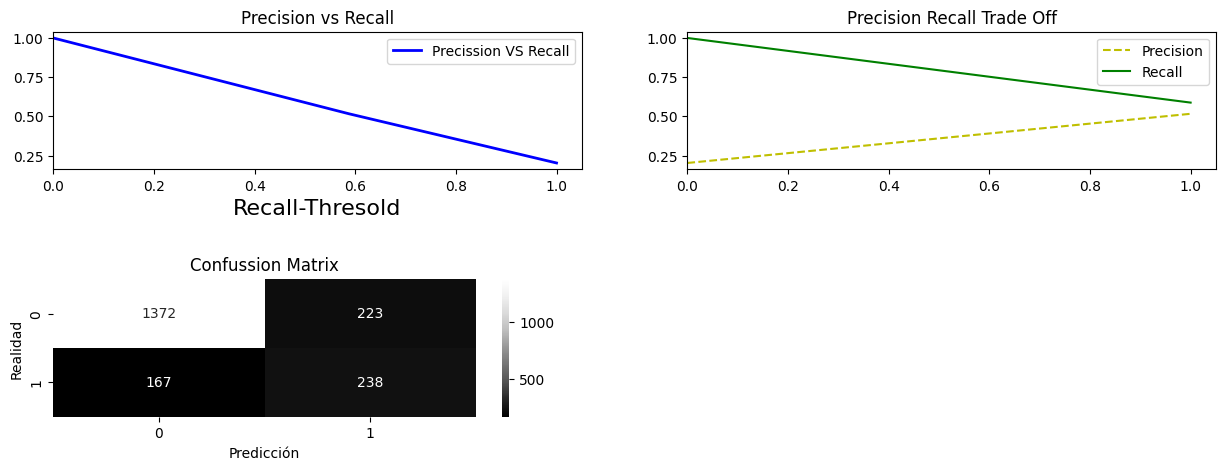

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1595
           1       0.52      0.59      0.55       405

    accuracy                           0.81      2000
   macro avg       0.70      0.72      0.71      2000
weighted avg       0.82      0.81      0.81      2000



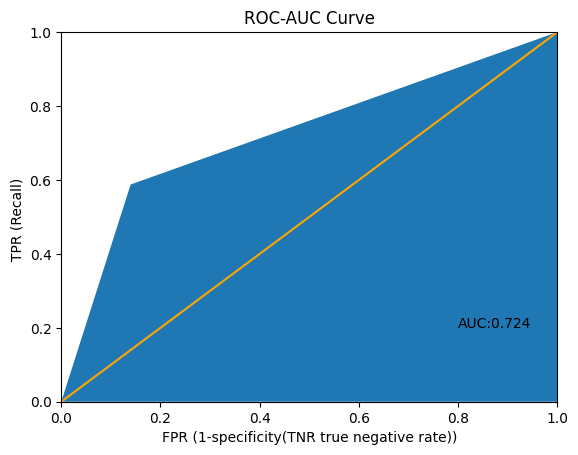

In [100]:
prediction = randomForestTuned.predict(x_test)

precisions,recalls,thresolds = precision_recall_curve(y_test,prediction)
Binary_classification_assessment(precisions,recalls,thresolds,prediction,y_test)

my_rocAuc(y_test,prediction)